<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/DeepGBM_(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [410]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Step 1 Complete: Libraries imported and seeds set")


✅ Step 1 Complete: Libraries imported and seeds set


In [411]:

# Step 2: Define DeepGBM Class
class DeepGBM:
    """
    Deep Gradient Boosting Machine combining LightGBM with Neural Networks
    """
    def __init__(self, n_classes=5, embedding_dim=16, hidden_units=[128, 64, 32]):
        self.n_classes = n_classes
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.gbm_model = None
        self.nn_model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def create_quantile_labels(self, y):
        """Create quantile-based labels for production values"""
        quantiles = np.quantile(y, [0.2, 0.4, 0.6, 0.8])
        labels = []
        label_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

        for val in y:
            if val <= quantiles[0]:
                labels.append(0)  # Very Low
            elif val <= quantiles[1]:
                labels.append(1)  # Low
            elif val <= quantiles[2]:
                labels.append(2)  # Medium
            elif val <= quantiles[3]:
                labels.append(3)  # High
            else:
                labels.append(4)  # Very High

        self.label_names = label_names
        self.quantiles = quantiles
        return np.array(labels)

    def add_noise_augmentation(self, X, y, noise_factor=0.01):
        """Add slight noise to training data for augmentation"""
        noise = np.random.normal(0, noise_factor, X.shape)
        X_augmented = X + noise
        return X_augmented, y

    def prepare_data(self, df, target_col='Production (M.Ton)', is_training=True, augment=False):
        """Prepare data for training/validation/testing"""
        # Separate features and target
        if target_col in df.columns:
            X = df.drop(columns=[target_col])
            y = df[target_col].values

            if is_training:
                # Create quantile-based labels
                y_labels = self.create_quantile_labels(y)
            else:
                # Apply existing quantiles for validation/test data
                y_labels = []
                for val in y:
                    if val <= self.quantiles[0]:
                        y_labels.append(0)
                    elif val <= self.quantiles[1]:
                        y_labels.append(1)
                    elif val <= self.quantiles[2]:
                        y_labels.append(2)
                    elif val <= self.quantiles[3]:
                        y_labels.append(3)
                    else:
                        y_labels.append(4)
                y_labels = np.array(y_labels)
        else:
            X = df
            y_labels = None

        # Handle missing values
        X = X.fillna(X.mean())

        # Scale features
        if is_training:
            X_scaled = self.scaler.fit_transform(X)
            # Apply data augmentation if requested
            if augment:
                X_scaled, y_labels = self.add_noise_augmentation(X_scaled, y_labels)
        else:
            X_scaled = self.scaler.transform(X)

        return X_scaled, y_labels, X.columns.tolist()

    def build_lightgbm(self, X_train, y_train, X_val, y_val):
        """Build and train LightGBM model"""
        # LightGBM parameters - Reduced complexity to prevent overfitting
        lgb_params = {
            'objective': 'multiclass',
            'num_class': self.n_classes,
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'num_leaves': 15,  # Reduced from 31
            'learning_rate': 0.01,  # Reduced from 0.05
            'feature_fraction': 0.7,  # Reduced from 0.9
            'bagging_fraction': 0.7,  # Reduced from 0.8
            'bagging_freq': 3,  # Reduced from 5
            'lambda_l1': 0.1,  # Added L1 regularization
            'lambda_l2': 0.1,  # Added L2 regularization
            'min_data_in_leaf': 20,  # Added minimum samples per leaf
            'max_depth': 6,  # Limited tree depth
            'verbose': -1,
            'random_state': 42
        }

        # Create datasets
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        # Train model with more conservative stopping
        self.gbm_model = lgb.train(
            lgb_params,
            train_data,
            valid_sets=[train_data, val_data],
            valid_names=['train', 'val'],
            num_boost_round=500,  # Reduced from 1000
            callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)]  # Earlier stopping
        )

        # Get GBM predictions as features for neural network
        gbm_train_pred = self.gbm_model.predict(X_train, num_iteration=self.gbm_model.best_iteration)
        gbm_val_pred = self.gbm_model.predict(X_val, num_iteration=self.gbm_model.best_iteration)

        return gbm_train_pred, gbm_val_pred

    def build_neural_network(self, input_dim, gbm_output_dim):
        """Build neural network that combines original features with GBM outputs"""
        # Input layers
        feature_input = layers.Input(shape=(input_dim,), name='features')
        gbm_input = layers.Input(shape=(gbm_output_dim,), name='gbm_output')

        # Feature processing branch - Reduced complexity
        x1 = layers.Dense(64, activation='relu')(feature_input)  # Reduced from 128
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.Dropout(0.5)(x1)  # Increased dropout from 0.3

        x1 = layers.Dense(32, activation='relu')(x1)  # Reduced from 64
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.Dropout(0.4)(x1)  # Increased dropout from 0.2

        # GBM output processing branch - Reduced complexity
        x2 = layers.Dense(16, activation='relu')(gbm_input)  # Reduced from 32
        x2 = layers.BatchNormalization()(x2)
        x2 = layers.Dropout(0.3)(x2)  # Increased dropout from 0.2

        # Combine branches
        combined = layers.Concatenate()([x1, x2])
        combined = layers.Dense(16, activation='relu')(combined)  # Reduced from 32
        combined = layers.BatchNormalization()(combined)
        combined = layers.Dropout(0.4)(combined)  # Increased dropout from 0.2

        # Output layer
        output = layers.Dense(self.n_classes, activation='softmax', name='output')(combined)

        # Create model
        model = keras.Model(inputs=[feature_input, gbm_input], outputs=output)

        # Compile model with L2 regularization
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Reduced learning rate
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def fit(self, X_train, y_train, X_val, y_val, epochs=200, batch_size=64):
        """Train the DeepGBM model"""
        print("Training LightGBM...")
        gbm_train_pred, gbm_val_pred = self.build_lightgbm(X_train, y_train, X_val, y_val)

        print("Building Neural Network...")
        self.nn_model = self.build_neural_network(X_train.shape[1], gbm_train_pred.shape[1])

        print("Training Neural Network...")
        # Callbacks - More aggressive overfitting prevention
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True  # Reduced patience
        )
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7  # More aggressive LR reduction
        )

        # Train neural network
        history = self.nn_model.fit(
            [X_train, gbm_train_pred], y_train,
            validation_data=([X_val, gbm_val_pred], y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        return history

    def predict(self, X):
        """Make predictions using the trained DeepGBM model"""
        # Get GBM predictions
        gbm_pred = self.gbm_model.predict(X, num_iteration=self.gbm_model.best_iteration)

        # Get neural network predictions
        nn_pred = self.nn_model.predict([X, gbm_pred])

        return np.argmax(nn_pred, axis=1), nn_pred

    def predict_proba(self, X):
        """Get prediction probabilities"""
        gbm_pred = self.gbm_model.predict(X, num_iteration=self.gbm_model.best_iteration)
        nn_pred = self.nn_model.predict([X, gbm_pred])
        return nn_pred

print("✅ Step 2 Complete: DeepGBM class defined")


✅ Step 2 Complete: DeepGBM class defined


In [412]:

# Step 3: Define utility functions
def load_and_preprocess_data():
    """Load and preprocess the CSV files"""
    try:
        train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
        val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
        test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

        print(f"Train data shape: {train_df.shape}")
        print(f"Validation data shape: {val_df.shape}")
        print(f"Test data shape: {test_df.shape}")

        return train_df, val_df, test_df
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        print("Please ensure train.csv, validation.csv, and test.csv are in the current directory")
        return None, None, None

def calculate_metrics(y_true, y_pred, y_pred_proba):
    """Calculate classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score (Weighted)': f1_weighted,
        'F1-Score (Macro)': f1_macro
    }

    return metrics

def detect_overfitting(history, threshold=0.1):
    """Detect overfitting based on training history"""
    train_acc = history.history['accuracy'][-10:]  # Last 10 epochs
    val_acc = history.history['val_accuracy'][-10:]

    avg_train_acc = np.mean(train_acc)
    avg_val_acc = np.mean(val_acc)

    gap = avg_train_acc - avg_val_acc

    print(f"\n=== Overfitting Analysis ===")
    print(f"Average Training Accuracy (last 10 epochs): {avg_train_acc:.4f}")
    print(f"Average Validation Accuracy (last 10 epochs): {avg_val_acc:.4f}")
    print(f"Accuracy Gap: {gap:.4f}")

    if gap > threshold:
        print(f"⚠️  OVERFITTING DETECTED! Gap > {threshold}")
        print("Recommendations:")
        print("- Increase dropout rates")
        print("- Add more regularization")
        print("- Reduce model complexity")
        print("- Collect more training data")
        print("- Use data augmentation")
    else:
        print(f"✅ Model appears well-balanced (gap <= {threshold})")

    return gap > threshold

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

def plot_training_history(history, title_suffix=""):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'Model Accuracy {title_suffix}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'Model Loss {title_suffix}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

print("✅ Step 3 Complete: Utility functions defined")


✅ Step 3 Complete: Utility functions defined


In [413]:

# ============================================================================
# STEP-BY-STEP EXECUTION STARTS HERE
# ============================================================================

print("\n" + "="*60)
print("🚀 STARTING STEP-BY-STEP EXECUTION")
print("="*60)

# Step 4: Load and examine data
print("\n📁 Step 4: Loading and examining data...")
train_df, val_df, test_df = load_and_preprocess_data()

if train_df is not None:
    print("✅ Data loaded successfully!")
    print(f"Training columns: {list(train_df.columns)}")
else:
    print("❌ Failed to load data. Please check file paths.")



🚀 STARTING STEP-BY-STEP EXECUTION

📁 Step 4: Loading and examining data...
Train data shape: (3942, 84)
Validation data shape: (845, 84)
Test data shape: (845, 84)
✅ Data loaded successfully!
Training columns: ['Production (M.Ton)', 'Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm', 'relative_humidity_2m(%)', 'Precipitation Corrected (mm)', 'Crop_Beans', 'Crop_Cabbage', 'Crop_Cauliflower', 'Crop_Garlic', 'Crop_Laushak', 'Crop_Onion', 'Crop_Radish', 'Crop_Tomato', 'District_Bagerhat', 'District_Bandarban', 'District_Barguna', 'District_Barishal', 'District_Bhola', 'District_Bogura', 'District_Brahmanbaria', 'District_Chandpur', 'District_Chapai Nawabganj', 'District_Chattogram', 'District_Chuadanga', 'District_Comilla', "District_Cox's Bazar", 'District_Dhaka',

In [414]:

# Step 5: Initialize model
print("\n🤖 Step 5: Initializing DeepGBM model...")
model = DeepGBM(n_classes=5, embedding_dim=16, hidden_units=[128, 64, 32])
print("✅ Model initialized!")



🤖 Step 5: Initializing DeepGBM model...
✅ Model initialized!


In [415]:

# Step 6: Prepare training data
print("\n🔄 Step 6: Preparing training data...")
X_train, y_train, feature_names = model.prepare_data(train_df, is_training=True)
print(f"✅ Training data prepared - Shape: {X_train.shape}")




🔄 Step 6: Preparing training data...
✅ Training data prepared - Shape: (3942, 83)


In [416]:

# Step 7: Prepare validation data
print("\n🔄 Step 7: Preparing validation data...")
X_val, y_val, _ = model.prepare_data(val_df, is_training=False)
print(f"✅ Validation data prepared - Shape: {X_val.shape}")



🔄 Step 7: Preparing validation data...
✅ Validation data prepared - Shape: (845, 83)


In [417]:

# Step 8: Prepare test data
print("\n🔄 Step 8: Preparing test data...")
X_test, y_test, _ = model.prepare_data(test_df, is_training=False)
print(f"✅ Test data prepared - Shape: {X_test.shape}")



🔄 Step 8: Preparing test data...
✅ Test data prepared - Shape: (845, 83)


In [418]:

# Step 9: Display quantile information
print(f"\n📊 Step 9: Quantile thresholds and label distribution")
print(f"Quantile thresholds: {model.quantiles}")
print(f"Label distribution in training:")
unique, counts = np.unique(y_train, return_counts=True)
for i, (label, count) in enumerate(zip(unique, counts)):
    print(f"  {model.label_names[label]}: {count} samples")



📊 Step 9: Quantile thresholds and label distribution
Quantile thresholds: [ 578.    1463.    3119.524 6540.92 ]
Label distribution in training:
  Very Low: 793 samples
  Low: 786 samples
  Medium: 786 samples
  High: 788 samples
  Very High: 789 samples


In [419]:

# Step 10: Train the model
print("\n🏋️ Step 10: Training DeepGBM model...")
print("="*50)
history = model.fit(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)
print("✅ Model training completed!")



🏋️ Step 10: Training DeepGBM model...
Training LightGBM...
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.403546	val's multi_logloss: 0.525819
Building Neural Network...
Training Neural Network...
Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2876 - loss: 2.1066 - val_accuracy: 0.4556 - val_loss: 1.4479 - learning_rate: 5.0000e-04
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4863 - loss: 1.3655 - val_accuracy: 0.6592 - val_loss: 1.1095 - learning_rate: 5.0000e-04
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6292 - loss: 1.0394 - val_accuracy: 0.7704 - val_loss: 0.7875 - learning_rate: 5.0000e-04
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7051 - loss: 0.8554 - val_accuracy: 0.7846 - val_loss: 0.6405 - learning_rate: 5.0000e-04
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7573 - loss: 0


📈 Step 11: Analyzing training history...


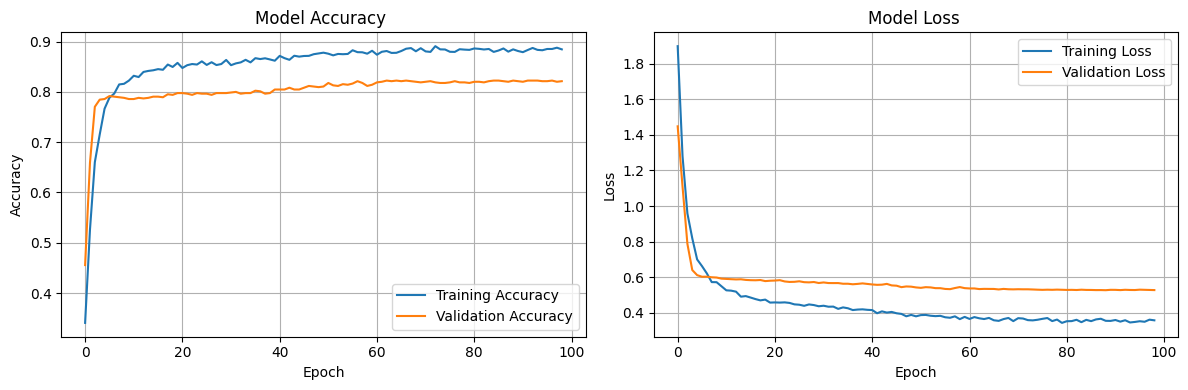


=== Overfitting Analysis ===
Average Training Accuracy (last 10 epochs): 0.8840
Average Validation Accuracy (last 10 epochs): 0.8215
Accuracy Gap: 0.0625
✅ Model appears well-balanced (gap <= 0.1)


In [420]:

# Step 11: Plot training history and detect overfitting
print("\n📈 Step 11: Analyzing training history...")
plot_training_history(history)
is_overfitting = detect_overfitting(history)


In [421]:
# Step 12: Validation predictions and evaluation
print("\n🔍 Step 12: Evaluating on validation data...")
val_pred_labels, val_pred_proba = model.predict(X_val)
val_metrics = calculate_metrics(y_val, val_pred_labels, val_pred_proba)

print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"  {metric}: {value:.4f}")



🔍 Step 12: Evaluating on validation data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Validation Metrics:
  Accuracy: 0.8225
  Precision: 0.8224
  Recall: 0.8225
  F1-Score (Weighted): 0.8223
  F1-Score (Macro): 0.8192



📊 Step 13: Plotting validation confusion matrix...


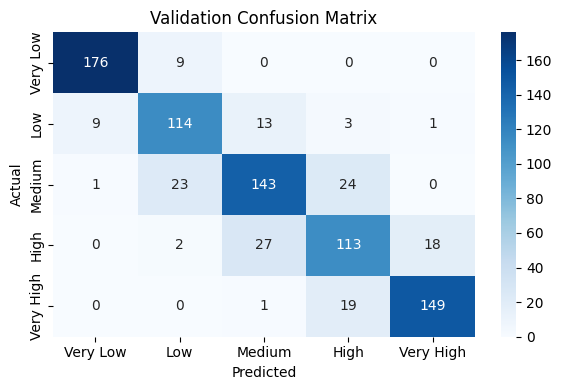

In [422]:
# Step 13: Plot validation confusion matrix
print("\n📊 Step 13: Plotting validation confusion matrix...")
plot_confusion_matrix(y_val, val_pred_labels, model.label_names,
                     "Validation Confusion Matrix")


In [423]:

# Step 14: Test predictions and evaluation
print("\n🎯 Step 14: Evaluating on test data...")
test_pred_labels, test_pred_proba = model.predict(X_test)
test_metrics = calculate_metrics(y_test, test_pred_labels, test_pred_proba)

print("Test Metrics:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")



🎯 Step 14: Evaluating on test data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Metrics:
  Accuracy: 0.8130
  Precision: 0.8152
  Recall: 0.8130
  F1-Score (Weighted): 0.8137
  F1-Score (Macro): 0.8132



📊 Step 15: Plotting test confusion matrix...


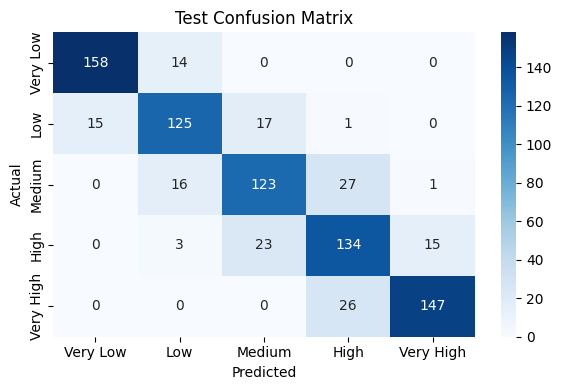

In [424]:
# Step 15: Plot test confusion matrix
print("\n📊 Step 15: Plotting test confusion matrix...")
plot_confusion_matrix(y_test, test_pred_labels, model.label_names,
                     "Test Confusion Matrix")


In [425]:

# Step 16: Detailed classification reports
print("\n📋 Step 16: Generating detailed classification reports...")
print("\n=== Detailed Classification Report (Validation) ===")
print(classification_report(y_val, val_pred_labels,
                          target_names=model.label_names))

print("\n=== Detailed Classification Report (Test) ===")
print(classification_report(y_test, test_pred_labels,
                          target_names=model.label_names))



📋 Step 16: Generating detailed classification reports...

=== Detailed Classification Report (Validation) ===
              precision    recall  f1-score   support

    Very Low       0.95      0.95      0.95       185
         Low       0.77      0.81      0.79       140
      Medium       0.78      0.75      0.76       191
        High       0.71      0.71      0.71       160
   Very High       0.89      0.88      0.88       169

    accuracy                           0.82       845
   macro avg       0.82      0.82      0.82       845
weighted avg       0.82      0.82      0.82       845


=== Detailed Classification Report (Test) ===
              precision    recall  f1-score   support

    Very Low       0.91      0.92      0.92       172
         Low       0.79      0.79      0.79       158
      Medium       0.75      0.74      0.75       167
        High       0.71      0.77      0.74       175
   Very High       0.90      0.85      0.88       173

    accuracy               

In [426]:
# Step 17: Final performance summary
print("\n📈 Step 17: Final Performance Summary")
print("="*50)
print(f"{'Metric':<20} {'Validation':<12} {'Test':<12}")
print("-" * 44)
for metric in val_metrics.keys():
    print(f"{metric:<20} {val_metrics[metric]:<12.4f} {test_metrics[metric]:<12.4f}")

print("\n🎉 ALL STEPS COMPLETED SUCCESSFULLY!")
print("="*60)



📈 Step 17: Final Performance Summary
Metric               Validation   Test        
--------------------------------------------
Accuracy             0.8225       0.8130      
Precision            0.8224       0.8152      
Recall               0.8225       0.8130      
F1-Score (Weighted)  0.8223       0.8137      
F1-Score (Macro)     0.8192       0.8132      

🎉 ALL STEPS COMPLETED SUCCESSFULLY!
